In [1]:
from functools import partial
import scipy as sp
import numpy as np
from skbio import DNA ,TabularMSA ,TreeNode ,DistanceMatrix ,Sequence
from skbio.alignment._pairwise import _compute_score_and_traceback_matrices
from skbio.alignment import global_pairwise_align_nucleotide
from skbio.alignment import local_pairwise_align_ssw


def kmer_distance(sequence1, sequence2, k=7, overlap=False):
    sequence1_kmers = set(map(str, sequence1.iter_kmers(k, overlap)))
    sequence2_kmers = set(map(str, sequence2.iter_kmers(k, overlap)))
    all_kmers = sequence1_kmers | sequence2_kmers
    shared_kmers = sequence1_kmers & sequence2_kmers
    number_unique = len(all_kmers) - len(shared_kmers)
    fraction_unique = number_unique / len(all_kmers)
    return fraction_unique


def guide_tree_from_sequences(sequences, metric=kmer_distance, display_tree=False):
    guide_dm = DistanceMatrix.from_iterable(sequences, metric=metric, key='id')
    guide_lm = sp.cluster.hierarchy.average(guide_dm.condensed_form())
    guide_tree = sp.cluster.hierarchy.to_tree(guide_lm)
    if display_tree:
        sp.cluster.hierarchy.dendrogram(
            guide_lm, labels=guide_dm.ids, orientation='right', link_color_func=lambda x: 'black')
    return guide_tree


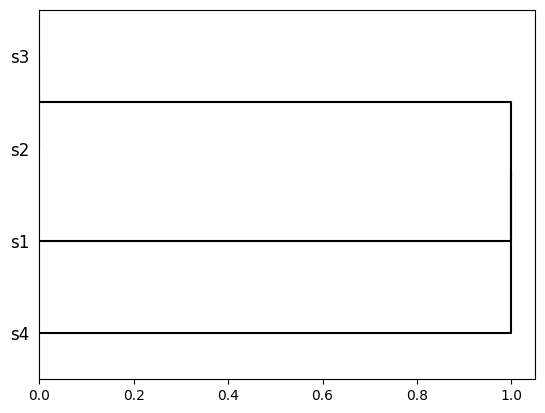

In [2]:

query_of_sequences = [DNA("ATGGCTTTCTGCACACAGTTGAT", {"id": "s1"}),
                      DNA("GTCCGCAATTGAGCGGGGCTCCA", {"id": "s2"}),
                      DNA("GTCCGCAATTGAGCGGGGCTCCA", {"id": "s3"}),
                      DNA("AAGCTCAGCGCACTTGGCTTAAG", {"id": "s4"}),
                      ]
guide_tree = guide_tree_from_sequences(query_of_sequences, display_tree=True)

In [3]:
def progressive_msa(sequences, pairwise_aligner, guide_tree=None,metric=kmer_distance):

    if guide_tree is None:
        guide_dm = DistanceMatrix.from_iterable(sequences, metric=metric, key='id')
        guide_lm = sp.cluster.hierarchy.average(guide_dm.condensed_form())
        guide_tree = TreeNode.from_linkage_matrix(guide_lm, guide_dm.ids)

    seq_lookup = {s.metadata['id']: s for i, s in enumerate(sequences)}
    c1, c2 = guide_tree.children
    c1_aln = seq_lookup[c1.name] if c1.is_tip() else progressive_msa(sequences, pairwise_aligner, c1)
    c2_aln = seq_lookup[c2.name] if c2.is_tip() else progressive_msa(sequences, pairwise_aligner, c2)

    alignment, _, _ = pairwise_aligner(c1_aln, c2_aln)

    return alignment

In [4]:
aligner = partial(global_pairwise_align_nucleotide,match_score = 6,mismatch_score = -2, gap_open_penalty=4, gap_extend_penalty=1)
MSA = progressive_msa(query_of_sequences, pairwise_aligner=aligner)
print(MSA)


TabularMSA[DNA]
----------------------------------
Stats:
    sequence count: 4
    position count: 34
----------------------------------
-AAGC--TCAGC--GCACTTG------GCTTAAG
ATGGCTTTCTGCACACAGTTGAT-----------
---G---TCCGCA---A-TTGAGCGGGGCTCCA-
---G---TCCGCA---A-TTGAGCGGGGCTCCA-


/home/codespace/.python/current/lib/python3.10/site-packages/skbio/alignment/_pairwise.py:595: EfficiencyWarning: You're using skbio's python implementation of Needleman-Wunsch alignment. This is known to be very slow (e.g., thousands of times slower than a native C implementation). We'll be adding a faster version soon (see https://github.com/biocore/scikit-bio/issues/254 to track progress on this).
  warn("You're using skbio's python implementation of Needleman-Wunsch "
